In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
import time
import itertools
from datetime import datetime
from pymongo import MongoClient

from src.config_tickets import ticket_lst
from src.scraping import WebScraping
from src.settings import HOST
from src.query_data import QueryData
from src.utilities import run_model_with_parameters, run_model_without_parameters
from Models.Lstm_geo_hybrid import GBM

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [3]:
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [4]:
def connect_2_dbServer():
    mongoClient = MongoClient(HOST)
    return mongoClient

In [5]:
client = connect_2_dbServer()
query = QueryData(client)

In [6]:
lst_ticket = query.get_list_ticket(index='VN 30 (VNI30)')
print(lst_ticket)
print(len(lst_ticket))

['Cotec Construction JSC', 'DHG Pharmaceutical JSC', 'Faros Construction Corp', 'FPT Corp', 'Gemadept Corp', 'Ho Chi Minh City Infrastructure Investment JSC', 'Ho Chi Minh City Development Joint Stock Commercial Bank', 'Hoa Phat Group JSC', 'Masan Group Corp', 'Military Commercial Joint Stock Bank', 'Mobile World Investment Corp', 'No Va Land Investment Group Corp', 'PetroVietnam Fertilizer and Chemicals Corp', 'Phu Nhuan Jewelry JSC', 'Refrigeration Electrical Engineering Corp', 'Sai Gon Thuong Tin Commercial Joint Stock Bank', 'Saigon Beer Alcohol Beverage Corp', 'Saigon Securities Incorporation', 'Vietnam Technological And Commercial Joint Stock Bank', 'Thanh Thanh Cong Tay Ninh JSC', 'Joint Stock Commercial Bank for Foreign Trade of Vietnam', 'Vietjet Aviation JSC', 'Vietnam Export Import Commercial Joint Stock Bank', 'Vietnam JSCmmercial Bank for Industry and Trade', 'Vietnam Prosperity Joint Stock Commercial Bank', 'Vietnam Dairy Products JSC', 'Vincom Retail JSC', 'Vingroup JSC'

['Cotec Construction JSC', 'DHG Pharmaceutical JSC', 'Faros Construction Corp', 'FPT Corp', 'Gemadept Corp']


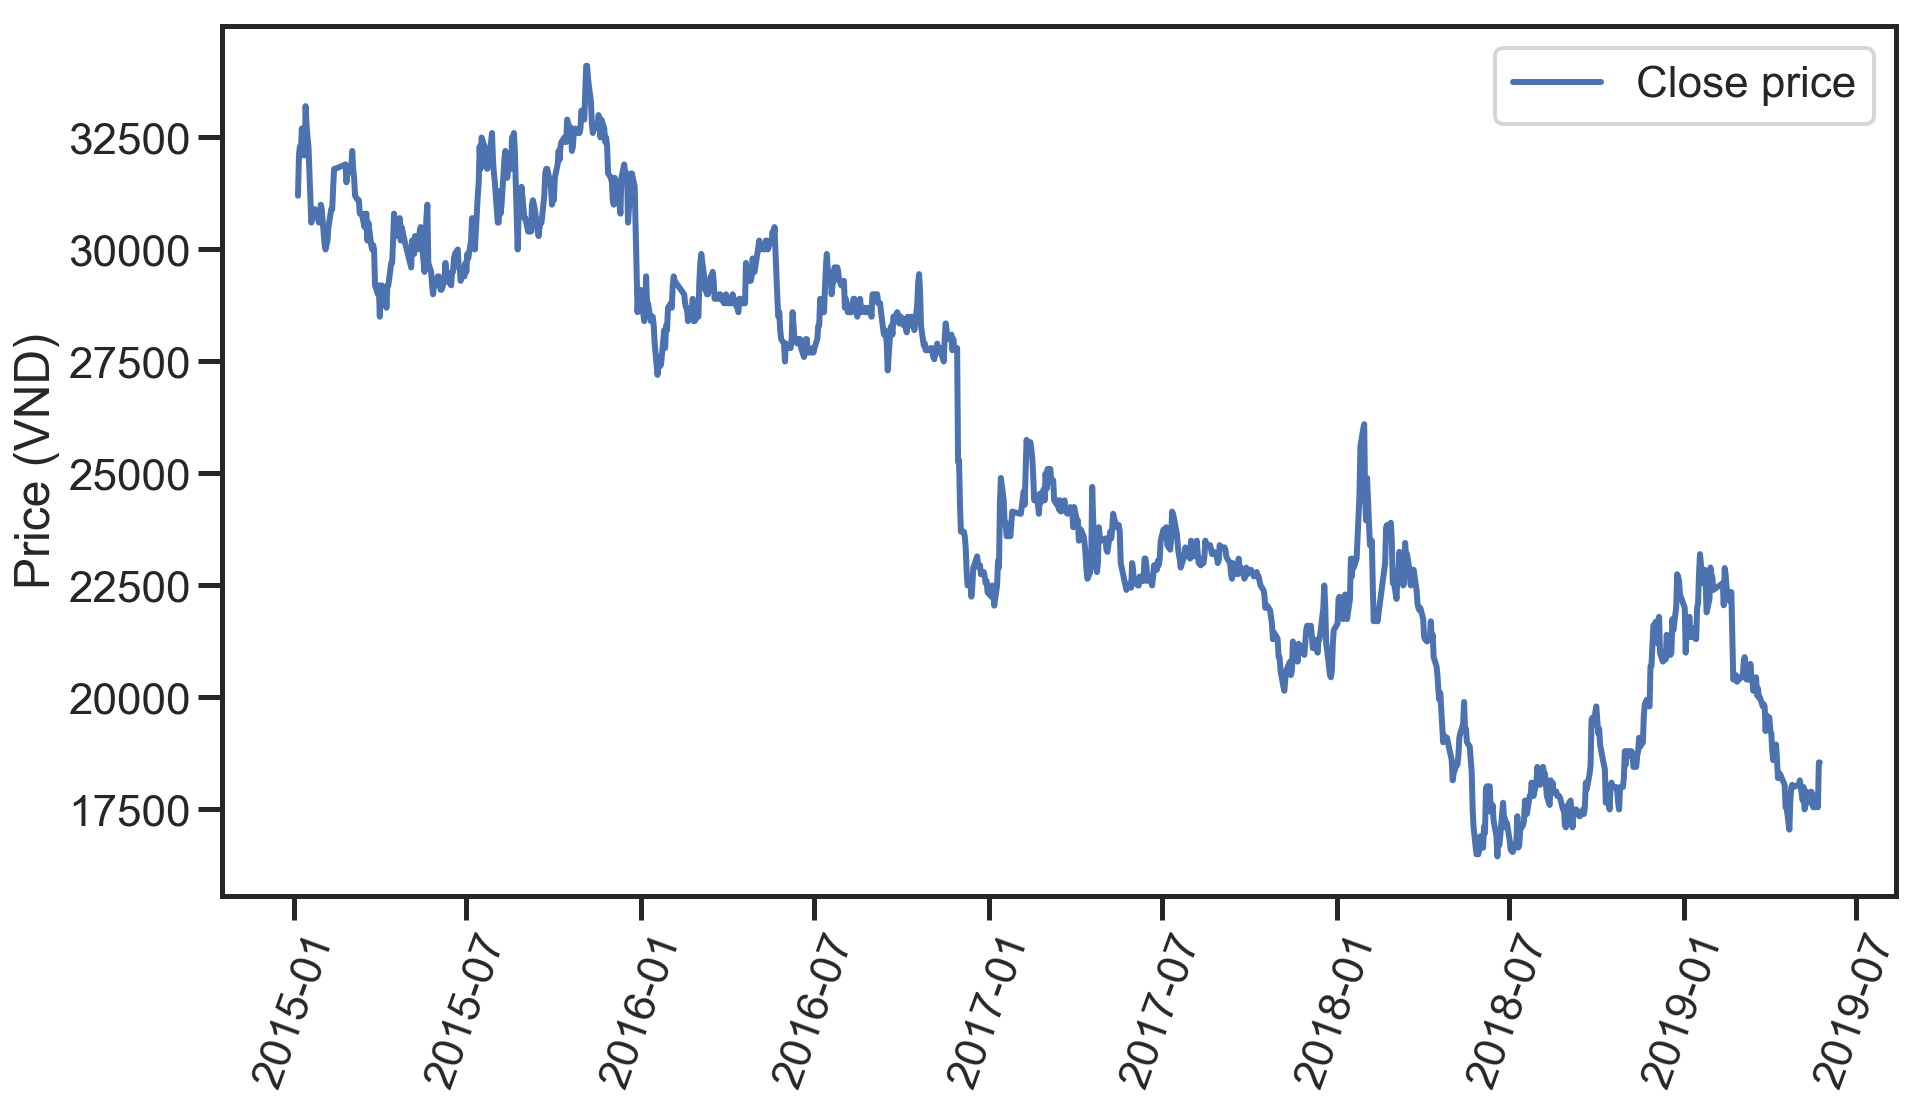

In [12]:
start = datetime(2015,1,1)
end = datetime(2019,1,1)

print(lst_ticket[:5])

df = query.get_historical_data(lst_ticket, start=start)
closed_price = dict()
for ticket in lst_ticket[3:10]:
    closed_price[ticket] = df[df.name == ticket]['close']

series = df[df.name == 'PetroVietnam Fertilizer and Chemicals Corp']['close']
plt.figure(figsize=(15,8))
plt.plot(series)
plt.xticks(rotation=70)
plt.legend(['Close price'])
plt.ylabel('Price (VND)')
plt.show()

In [8]:
from statsmodels.tsa.stattools import pacf, acf

def calculate_acf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    acf_value, confint = acf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - acf_value
    confint_upper = confint[:, 1] - acf_value
    return acf_value, confint_upper, confint_lower


def calculate_pacf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    pacf_value, confint = pacf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - pacf_value
    confint_upper = confint[:, 1] - pacf_value
    return pacf_value, confint_upper, confint_lower

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def evaluation(validation):
    mse = mean_squared_error(validation['y'], validation['yhat'])
    rmse = root_mean_squared_error(validation['y'], validation['yhat'])
    mae = mean_absolute_error(validation['y'], validation['yhat'])
    mape = mean_absolute_percentage_error(validation['y'], validation['yhat'])
    result = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
    }
    return result

start_train = 0.8
end_train = 0.95

In [9]:
def gen_order(p, d, q):
    return list(itertools.product(p, d, q))

def gen_ann(lags, hl):
    hl1 = hl
    hl2 = [int(i / 2) for i in hl]
    return list(itertools.product(lags, hl1, hl2))

## ARIMA

In [10]:
for ticket in lst_ticket[12:14]:
    time_series = df[df.name == ticket]['close']
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    p = range(0,3)
    d = range(0,2)
    q = range(0,1)
    lst_order = gen_order(p,d,q)
    
    print(ticket)
    
    lst_result = []
    for order in lst_order:
        print(order)
        result = run_model_with_parameters(train, test, model_selection='ARIMA', order=order)
        if result['status']:
            validation = result['model'].validate(test)
            time.sleep(1)
#             print('Testing result:', result['test_evaluation'])
            _result = result['test_evaluation']
            _result['training time'] = result['training_time']
            _result['order'] = result['order']
            lst_result.append(_result)
        else:
            print('None')
    df_result = pd.DataFrame(lst_result)
    df_result.to_csv(ticket+' result.csv', index=False)
    print(df_result)

PetroVietnam Fertilizer and Chemicals Corp
(0, 0, 0)
(0, 1, 0)
(1, 0, 0)
(1, 1, 0)
(2, 0, 0)
(2, 1, 0)
          mae      mape             mse      order        rmse  training time
0 18818.18182 100.00000 355402909.09091  (0, 0, 0) 18852.13275        0.01052
1   227.27273   1.21581     89909.09091  (0, 1, 0)   299.84845        0.01276
2   230.50175   1.23259     91313.21121  (1, 0, 0)   302.18076        0.02470
3   228.15644   1.22098     87517.80482  (1, 1, 0)   295.83408        0.01482
4   231.42215   1.23791     89042.52903  (2, 0, 0)   298.39995        0.03252
5   228.65666   1.22368     87648.56283  (2, 1, 0)   296.05500        0.01464
Phu Nhuan Jewelry JSC
(0, 0, 0)
(0, 1, 0)
(1, 0, 0)
(1, 1, 0)
(2, 0, 0)
(2, 1, 0)
           mae      mape               mse      order         rmse  \
0 101243.07273 100.00000 10256592247.54545  (0, 0, 0) 101274.83521   
1    967.23636   0.94575     1806409.23636  (0, 1, 0)   1344.02725   
2    977.26479   0.95590     1803709.93058  (1, 0, 0)   134